<a href="https://colab.research.google.com/github/YYC-CHUAN/dip-CTuse/blob/main/Super_resolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code for **super-resolution** (figures $1$ and $5$ from main paper).. Change `factor` to $8$ to reproduce images from fig. $9$ from supmat.

You can play with parameters and see how they affect the result.

In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
!git clone https://github.com/YYC-CHUAN/dip-CTuse.git
!mv dip-CTuse/* ./

Cloning into 'dip-CTuse'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 384 (delta 48), reused 7 (delta 7), pack-reused 315 (from 2)
Receiving objects: 100% (384/384), 7.62 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (135/135), done.


# Import libs

In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *



import torch
import torch.optim


from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize = -1
factor = 4 # 8
enforse_div32 = 'CROP' # we usually need the dimensions to be divisible by a power of two (32 in this case)
PLOT = True

# To produce images from the paper we took *_GT.png images from LapSRN viewer for corresponding factor,
# e.g. x4/zebra_GT.png for factor=4, and x8/zebra_GT.png for factor=8
path_to_image = 'data-new/Super-resolution/a1.png'

# Load image and baselines

HR and LR resolutions: (576, 384), (144, 96)


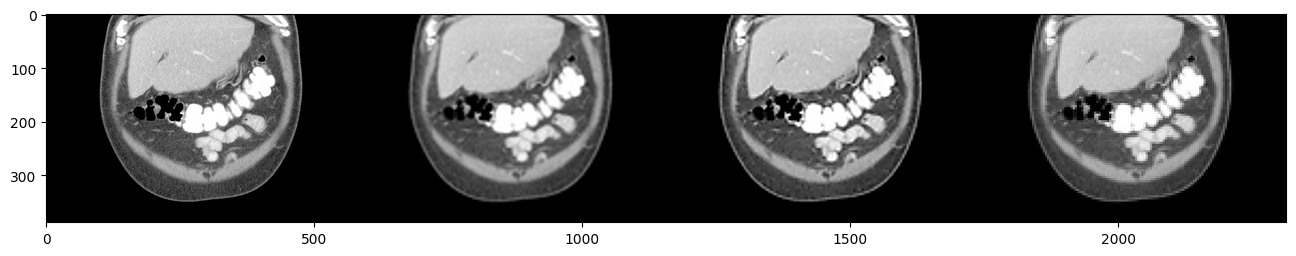

PSNR bicubic: 29.9910   PSNR nearest: 27.2725


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
# Starts here
imgs = load_LR_HR_imgs_sr(path_to_image , imsize, factor, enforse_div32)

imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np'] = get_baselines(imgs['LR_pil'], imgs['HR_pil'])

if PLOT:
    plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], imgs['sharp_np'], imgs['nearest_np']], 4,12);
    print ('PSNR bicubic: %.4f   PSNR nearest: %.4f' %  (
                                        compare_psnr(imgs['HR_np'], imgs['bicubic_np']),
                                        compare_psnr(imgs['HR_np'], imgs['nearest_np'])))

# Set up parameters and net

In [ ]:

input_depth = 32

INPUT =     'noise'
pad   =     'reflection'
OPT_OVER =  'net'
KERNEL_TYPE='lanczos2'

LR = 0.01
tv_weight = 0.0

OPTIMIZER = 'adam'


if factor == 4:
    num_iter = 2000
    reg_noise_std = 0.03
    print('factor = 4')
elif factor == 8:
    num_iter = 4000
    reg_noise_std = 0.05
    print('factor = 8')
else:
    assert False, 'We did not experiment with other factors'

factor = 4


In [ ]:
net_input = get_noise(input_depth, INPUT, (imgs['HR_pil'].size[1], imgs['HR_pil'].size[0])).type(dtype).detach()

NET_TYPE = 'skip' # UNet, ResNet
net = get_net(input_depth, 'skip', pad,
              skip_n33d=128,
              skip_n33u=128,
              skip_n11=4,
              num_scales=5,
              upsample_mode='bilinear').type(dtype)

mse = torch.nn.MSELoss().type(dtype)

img_LR_var = np_to_torch(imgs['LR_np']).type(dtype)

downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

# Define closure and optimize

In [ ]:
psnr_history = []
psrn_HR_list = []
psrn_LR_list = []

def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out_HR = net(net_input)
    out_LR = downsampler(out_HR)

    total_loss = mse(out_LR, img_LR_var)

    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_LR = compare_psnr(imgs['LR_np'], torch_to_np(out_LR))
    psnr_HR = compare_psnr(imgs['HR_np'], torch_to_np(out_HR))
    print ('Iteration %05d    PSNR_LR %.3f   PSNR_HR %.3f' % (i, psnr_LR, psnr_HR), '\r', end='')


    import pandas as pd

    df_psnr_history = pd.DataFrame(columns=['Iteration', 'Loss', 'PSNR_LR', 'PSNR_HR'])

    def update_psnr_table(i, loss, psnr_LR, psnr_HR):
        df_new_row = {'Iteration': i, 'Loss': loss, 'psnr_LR': psnr_LR, 'PSNR_HR': psnr_HR}

    psrn_LR_list.append(psnr_LR)
    psrn_HR_list.append(psnr_HR)

    # History
    psnr_history.append([psnr_LR, psnr_HR])

    if PLOT and i % 100 == 0:
        out_HR_np = torch_to_np(out_HR)
        plot_image_grid([imgs['HR_np'], imgs['bicubic_np'], np.clip(out_HR_np, 0, 1)], factor=13, nrow=3)
        print(f"iteration:{i}")
        print(f"Last 100 iterations PSNR_LR: {psrn_LR_list[-100:]}")
        print(f"Last 100 iterations PSNR_HR: {psrn_HR_list[-100:]}")

        total_psnr_HR_sum = sum(psrn_HR_list)
        total_psnr_LR_sum = sum(psrn_LR_list)

        psnr_history.append([psnr_LR, psnr_HR])


    i += 1

    return total_loss

Starting optimization with ADAM


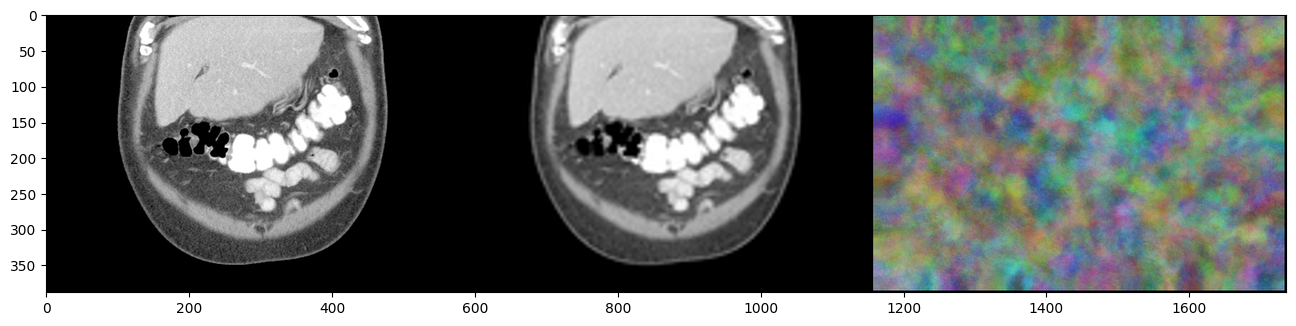

iteration:0
Last 100 iterations PSNR_LR: [8.194806914654876]
Last 100 iterations PSNR_HR: [8.129988161006795]


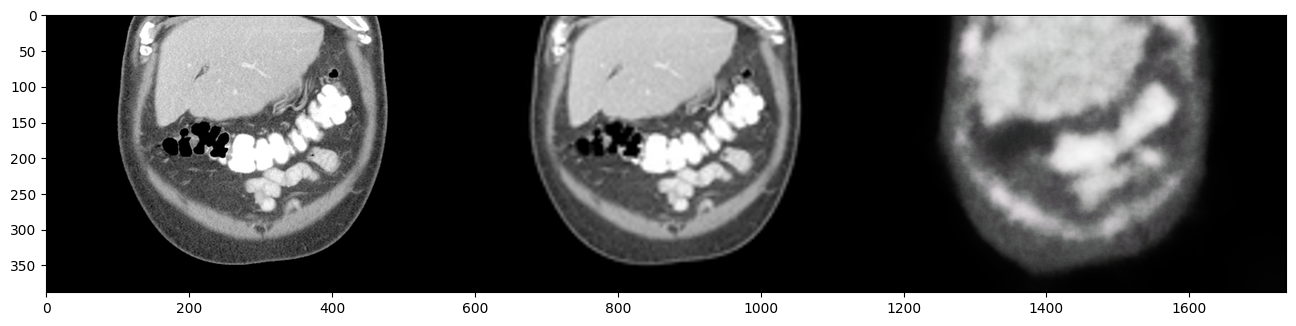

iteration:100
Last 100 iterations PSNR_LR: [8.705704510992863, 8.394754021358796, 8.163896607902693, 7.163063137603087, 9.221805161066284, 11.683813790446864, 12.248435087943426, 13.56959588147774, 14.510215131084864, 15.386648812793391, 15.79343941641093, 15.950549033661876, 15.976156032056696, 16.034973036687212, 15.860668032895227, 15.899435185789223, 16.00565197355763, 16.076580974005978, 16.26736956475801, 16.01994569859742, 16.466202157384203, 17.102068422287736, 16.253752206101186, 16.69922739076291, 16.80337556330545, 17.086902696869753, 16.980045045134936, 17.081201237848788, 16.979559223257542, 17.110747825417917, 17.237482116061308, 17.20651925819897, 17.202925666426147, 17.36950000251789, 17.35898127020637, 17.467789760762535, 17.448410707549066, 17.535788228040417, 17.290002063415784, 17.474495514385776, 17.500206870964977, 17.747289401459525, 17.673368775079087, 17.5792297969457, 17.727325977253038, 17.75252950464513, 17.726775831415825, 17.671496286987708, 17.59467060041

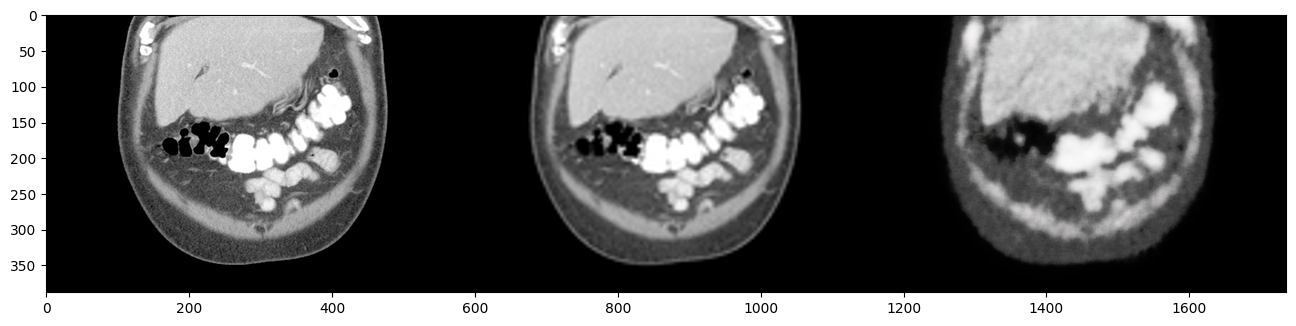

iteration:200
Last 100 iterations PSNR_LR: [22.094816183177844, 21.903237030201232, 21.96671299650673, 21.746472899501633, 22.24029161848358, 22.141409633166113, 21.942640476018216, 21.98150057199287, 22.06744180948207, 22.119346145971214, 22.185699436654325, 22.454650979857725, 22.21520021387713, 22.030230419852103, 22.40564991993812, 22.804882729884856, 22.258457363523934, 22.9258736235302, 22.315724801444965, 22.66432609138542, 22.41839533477343, 22.822583713308617, 22.61619603009926, 22.76911615159961, 22.810332762199323, 22.75683420044824, 22.815540799591677, 22.808835033711617, 22.96201078178474, 22.479951431850477, 22.99174254747268, 22.738110744704723, 23.135293391131167, 22.954607688521996, 22.761680198431776, 23.16532797719269, 22.889006666739327, 23.22384968835828, 23.341499459026444, 23.22922211834094, 22.670834548653325, 22.818609415148046, 22.84100317621825, 23.457634058200973, 23.01072950971173, 23.328187065007317, 23.41245883788134, 23.375187452649513, 23.54553212057843

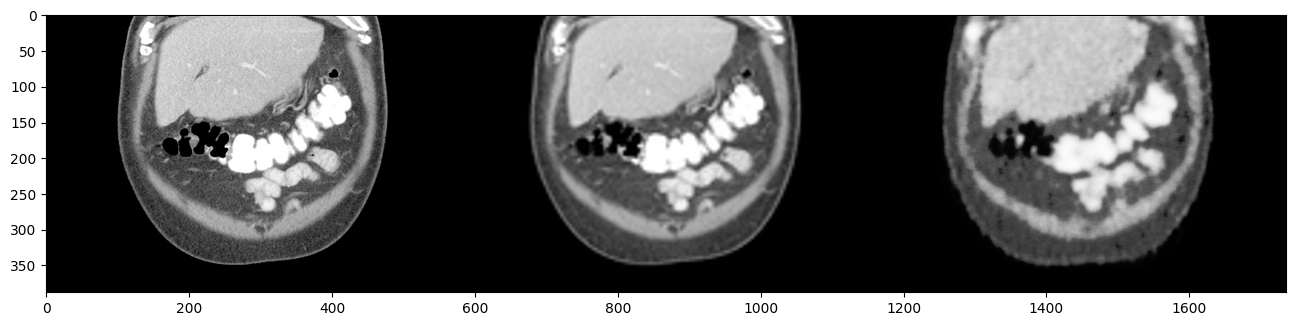

iteration:300
Last 100 iterations PSNR_LR: [24.10703223484112, 25.070600959675907, 24.363596328007304, 24.14070787585073, 23.950474411184274, 24.571527970715028, 24.866770588477912, 24.525704535436596, 23.90706129116548, 24.583509829212993, 24.488759155060457, 25.00443820552284, 24.779841982676633, 25.044626296806946, 24.6463065795516, 24.434017667411773, 24.835461314122075, 24.949473652116062, 24.974537264860174, 24.872395403477746, 25.27880798720434, 25.075587654277605, 25.099079402842168, 25.21757453680752, 25.154482196892296, 25.53653460985104, 25.09039358757244, 24.87488637245955, 25.5898810266789, 25.13318413281406, 25.4459796941283, 25.321525682987417, 25.377046706386896, 25.114947322701173, 25.609848893332874, 25.2146408917249, 25.20556092586888, 24.632007862712094, 25.310831208736182, 25.40255419911704, 25.759258431529005, 25.824469994043866, 25.669257032092446, 25.37285784295974, 24.898289543279247, 25.861653135016283, 25.51127569468232, 25.567466660777065, 25.90509692023742,

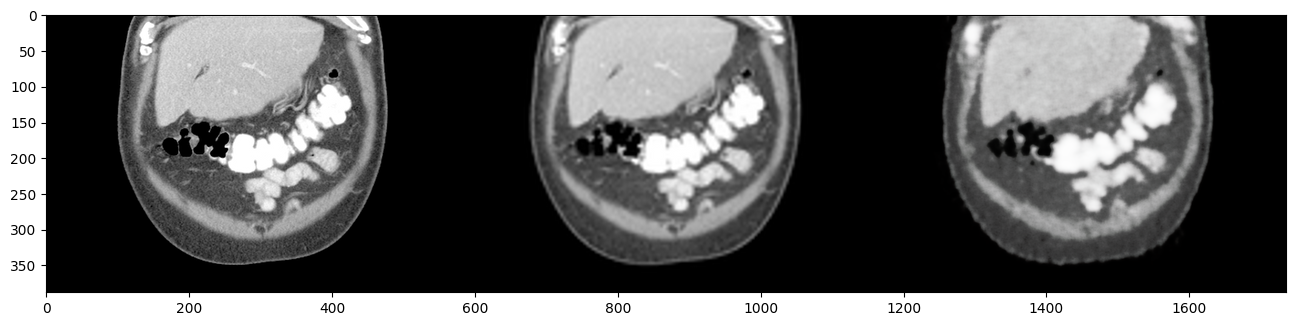

iteration:400
Last 100 iterations PSNR_LR: [26.27737724344054, 26.79534149525471, 26.83576918556319, 26.162221969763184, 26.357275614130064, 26.390901244821954, 26.308554688659097, 26.650773543259938, 26.56486517371265, 26.643195706245223, 26.615875914878387, 26.790319144178607, 26.87776522590446, 26.677189236642107, 26.734965125408895, 26.63688848926121, 26.710087279867587, 26.753107781619065, 26.59809897774764, 26.57101637042299, 26.66524125357952, 26.44343920947916, 26.925264924960253, 25.91041557476004, 26.896589484073065, 26.991888286751042, 26.20448537657268, 26.85732006391732, 26.66855326217305, 27.25282527237912, 26.60603023921741, 26.966542015988555, 27.261923634737816, 26.70714281884477, 27.102451784091887, 26.996881314930047, 27.11354870872984, 27.11209760650224, 27.119525453198733, 26.918038380889946, 26.96939935007905, 27.095684750017387, 27.040257799604397, 27.379917730313714, 27.291199252694007, 26.727951949152484, 27.52072142931297, 26.901068009190897, 27.14218234030358

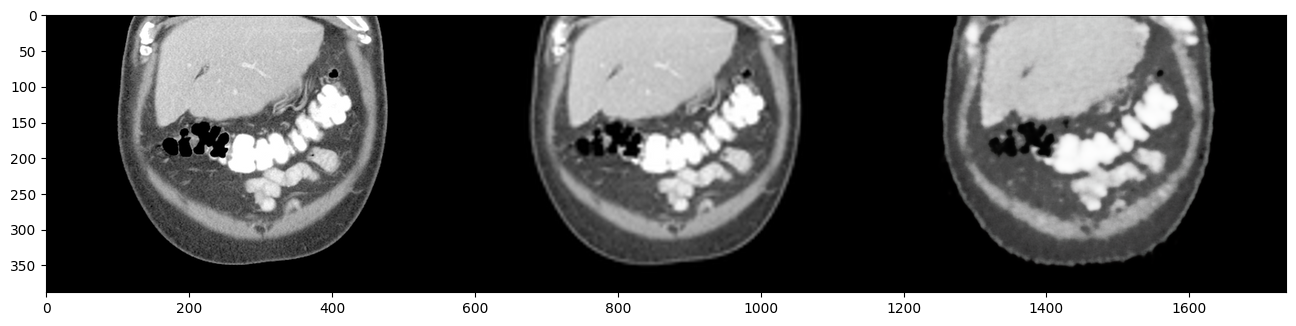

iteration:500
Last 100 iterations PSNR_LR: [27.811251846479855, 27.818832541283285, 27.842155231512624, 28.134665399668485, 28.052395325907042, 28.014384056544213, 27.667803559288025, 27.808914118614616, 28.0857108366668, 28.242704326940068, 27.93131292999068, 28.29193667453724, 27.962644451434244, 28.314465310500083, 28.009900645216455, 28.06364888285586, 28.332168979832492, 28.15553208852498, 28.10582291702484, 28.455976224821246, 28.168244640394597, 27.87979749326473, 28.008777097939728, 28.187065657167587, 27.966846304198327, 28.204007079703715, 28.072262909423582, 28.54416262321255, 28.182589215873442, 28.509797054009024, 28.047434853172707, 28.267856510579172, 28.242989267721793, 28.043599757664637, 28.178405757250502, 28.136420671468837, 28.291860570607042, 28.67072901665327, 28.13868717706283, 28.411328028232745, 28.434606946605136, 28.654772036854826, 28.34837665017911, 28.312862402522242, 28.464939017916045, 28.571993526852918, 28.40286517442493, 28.541933822875603, 28.677052

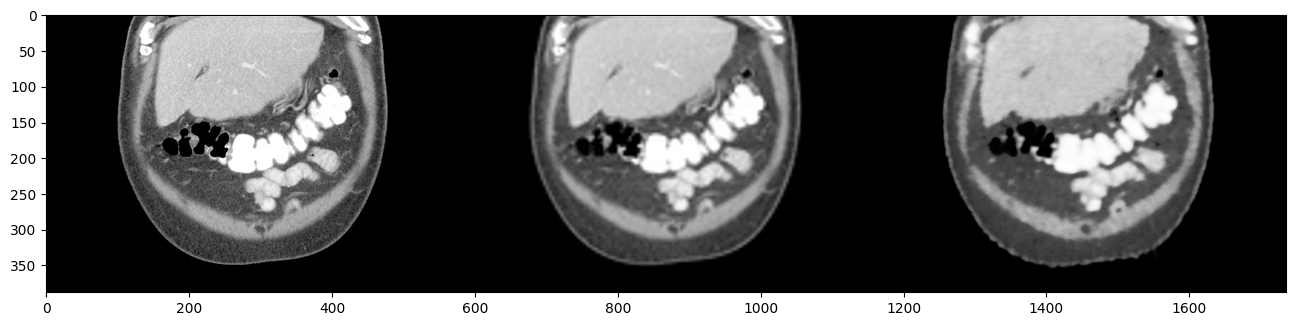

iteration:600
Last 100 iterations PSNR_LR: [28.59973922383597, 28.749961968683504, 28.649695545361226, 28.76008230600838, 28.95462925129308, 29.021777122524224, 29.253666340989145, 29.07169094001757, 28.961214059597516, 28.902515011497066, 29.03339131222125, 28.997500728009303, 29.00157899520243, 29.187965740020708, 28.953654072590602, 29.230082237695953, 28.729332280718584, 29.14482341043415, 28.85656885800497, 29.280539651790946, 29.04682281931979, 29.28002356688274, 29.29978730208443, 29.47927351284998, 28.97135767711676, 29.279800482070115, 29.292920342615602, 28.964063793504575, 29.569558697793834, 29.12662429524925, 29.210053199269247, 28.658796075773854, 29.17582459675543, 29.009390943228624, 29.10028834035936, 29.22565487193228, 29.172051444525163, 29.18195343483014, 29.11770724250189, 28.785084159317933, 29.231121323340545, 29.33317964490268, 29.246697085632675, 29.459283079598116, 29.30435604557401, 29.157894407192458, 29.330845624725818, 29.092111451413366, 28.86714672366184

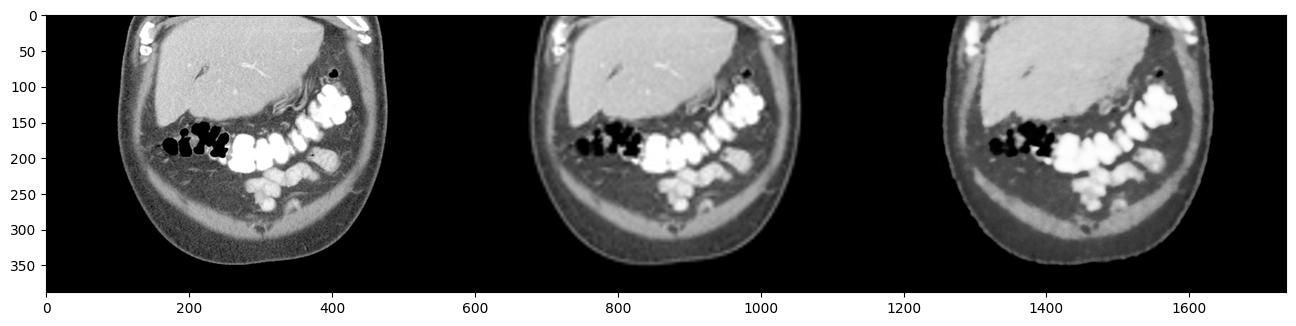

iteration:700
Last 100 iterations PSNR_LR: [29.835351445732854, 29.71986365243253, 29.70266259361579, 29.923968074544945, 29.611182175216477, 30.024786758239603, 28.964795699270063, 29.58865459936637, 30.03717011464625, 29.81650068152049, 29.810695739703714, 29.466406876687948, 29.74213700094677, 30.226067892310606, 29.81004806851776, 29.58402068499214, 30.102899137889203, 29.829684173451003, 29.992795855958846, 29.580164758869792, 30.297533047681636, 29.539400423566434, 30.156565248457063, 30.073695495630943, 30.09453396182931, 29.91505200688043, 29.811651394664985, 30.262114726117723, 29.85046704951678, 29.969255177469456, 29.997382443701284, 29.66307711173404, 29.817128878152804, 29.668232158355092, 30.323554631929337, 30.019171273049267, 29.893226778600358, 29.778481281292812, 30.13124414157045, 29.857541286468333, 30.001178656787854, 29.924461808009045, 29.882353596546928, 30.05319715717193, 30.009963918334307, 30.08089410706595, 30.453436335311416, 30.206661101345958, 30.15076875

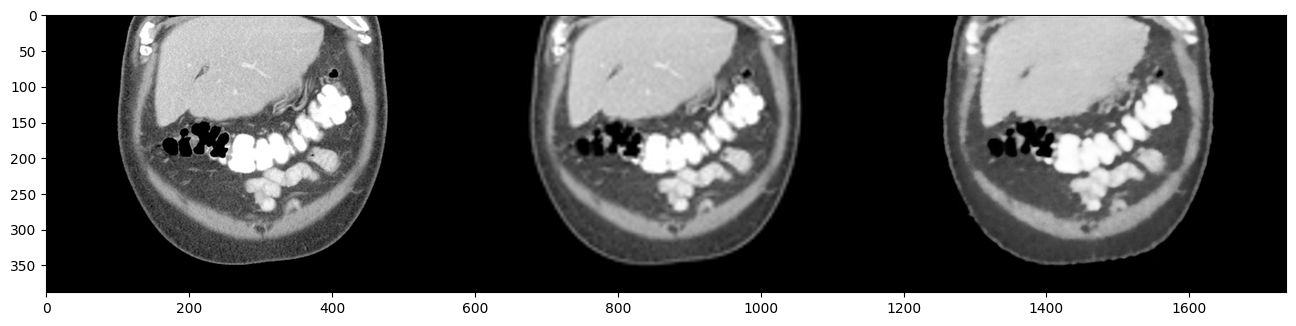

iteration:800
Last 100 iterations PSNR_LR: [30.48453045139558, 30.6988966916362, 30.442216047977762, 30.72455823556156, 30.16323096158323, 30.468627056517782, 30.60209965142562, 30.377330817559432, 30.812884913461946, 30.069407519165225, 30.566344799266204, 30.14517343219417, 30.7431151231774, 30.429770371109235, 30.248216005932107, 30.73106709773985, 29.985446358592466, 30.457257808814386, 30.139409910035884, 30.614927971580244, 30.07808326076837, 30.51762444958446, 30.392825258310907, 30.204164885457377, 30.14443036307494, 30.581560222578336, 30.518689262167207, 30.774217241626065, 30.491436273412084, 30.567542225313545, 30.110269920881613, 31.04289588369682, 30.71238269837094, 30.48335097716229, 30.733173060428634, 30.736560499270208, 30.750866365439435, 30.74032493202037, 30.680791941470332, 30.95343940148807, 30.52356453397237, 30.912027749133806, 30.81760522759415, 30.382270262957217, 30.540759859610176, 30.1433477438474, 30.837167608085405, 30.499228722778188, 30.939811155051643

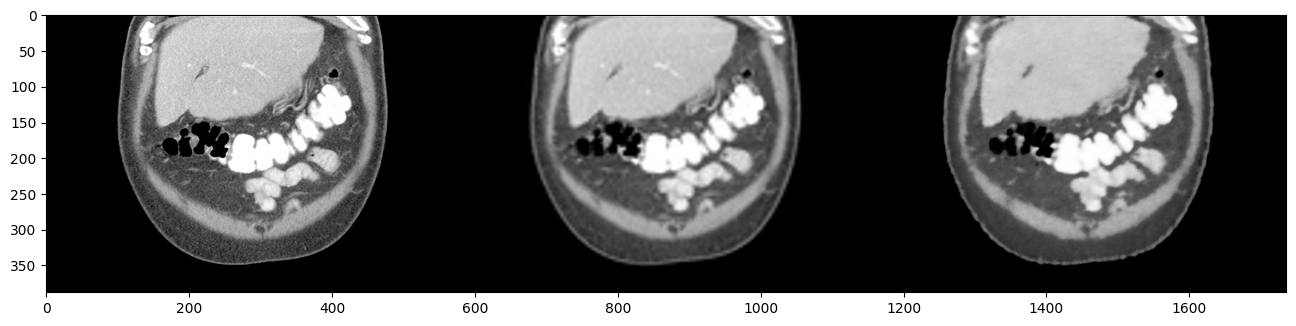

iteration:900
Last 100 iterations PSNR_LR: [31.24808178155003, 31.35342340857164, 31.522848415100203, 30.981951324823285, 31.181177527539887, 31.40858581909505, 31.46019414866355, 31.249875143677883, 31.40135911975278, 30.91144597693946, 31.342446607249236, 31.50723275017483, 31.284513100936664, 31.28186373900128, 31.385623238362914, 31.516298631607377, 31.274518784575193, 31.391783805924458, 31.429721294580023, 31.240828994914626, 31.325609559703025, 31.589109996966517, 31.567914033902582, 31.571631693598768, 31.40205737455838, 31.620696728536867, 31.27690465666372, 31.542969722338235, 31.257323191235535, 30.86686948336527, 31.46588727810755, 31.362118830691852, 31.447804112806423, 31.4458774938953, 31.357137180851062, 31.45503854702035, 31.249560660678625, 31.52884210647493, 31.18822044584199, 31.16883852137946, 31.491852107554084, 31.62773923667103, 31.12856029890323, 31.574711175229993, 31.568175516731806, 31.581467919648833, 31.339564450857363, 31.373768662258897, 31.6474465428923

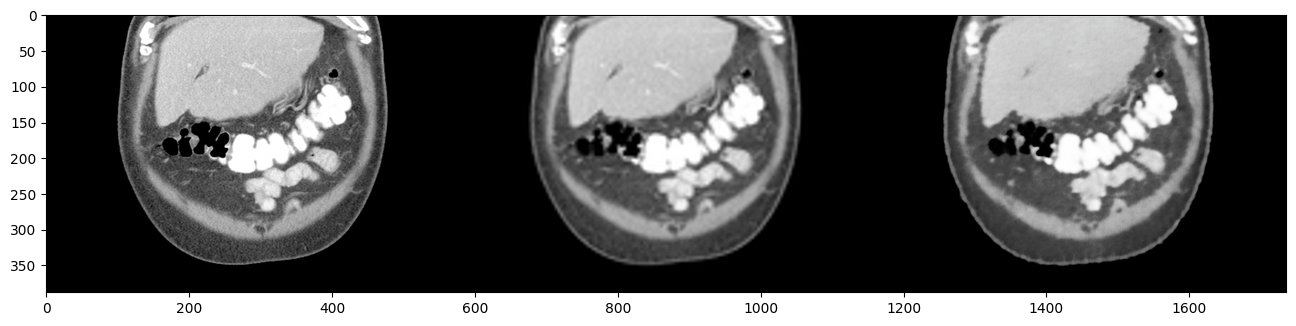

iteration:1000
Last 100 iterations PSNR_LR: [31.31426038179462, 31.86693974898711, 32.126516221588936, 31.65616724399569, 31.97436732586464, 31.908695239427814, 31.904265388284877, 31.86198717356948, 31.820797221790137, 31.922171472940136, 31.879418070479083, 31.505440639771244, 31.783796205864576, 31.522706099115698, 31.87247290009299, 31.310698242045156, 31.701681524942714, 31.840265258125115, 31.890060435301592, 31.623999592882733, 31.872108777621065, 32.19786080456524, 31.853636080067005, 32.136625416012386, 31.99643518908352, 31.733698604413405, 32.120331812667814, 32.04084029669345, 32.04072578129403, 31.586530577724194, 32.34516584071325, 31.444657631894927, 31.915422174558913, 32.074074255032265, 31.977379544622142, 31.652392713238854, 32.12382715478278, 32.245474092498135, 31.884807488469914, 32.09992687977701, 32.01773140168432, 32.07547184939428, 32.20262793911848, 32.07561770108246, 32.2250222360049, 31.931198365294044, 32.01590062297231, 31.889638807851092, 32.287765968336

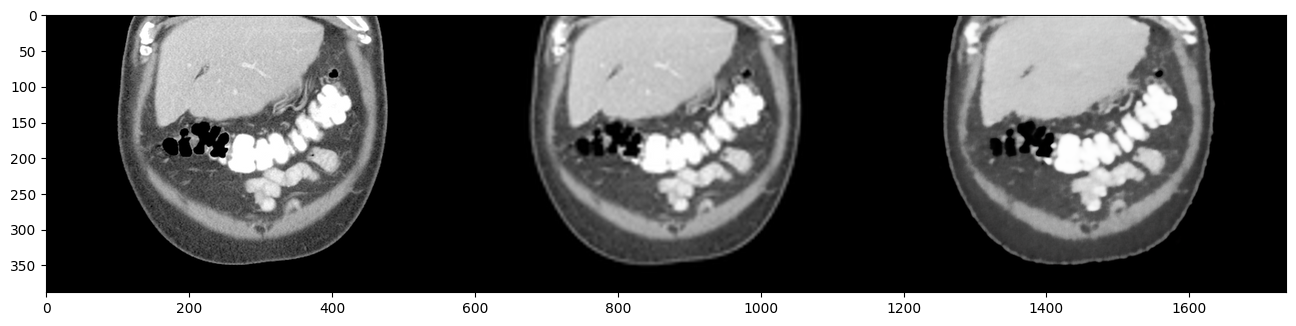

iteration:1100
Last 100 iterations PSNR_LR: [32.4054518312518, 32.502315922227496, 31.910267277562877, 32.213559811095514, 32.389924930713775, 32.46471080938212, 31.91058986708502, 32.32834137850355, 31.944132575500053, 32.62509497766579, 32.010605532796305, 32.30553435269438, 32.083142305681385, 32.308260838465436, 32.41125393307076, 32.27931311824926, 32.12014162741524, 32.1106807519427, 31.947347046959642, 32.45761174066865, 31.68869377456985, 32.295023100595294, 32.03126640339629, 32.276878656007725, 31.61461058313588, 32.27980662726149, 32.201124714239775, 31.704877871754753, 32.35792037857917, 32.263295053160306, 32.16157799200027, 32.12753205481418, 32.69958680452603, 32.003626147162905, 32.194449965959315, 32.355769873360444, 32.263013164541015, 32.57398884224253, 32.398356772454164, 32.61692622814169, 32.53673681382851, 32.65740217783961, 32.732644737937385, 32.69371912782728, 32.22006867377885, 32.93041017675095, 32.40850787990561, 32.3824404171599, 32.6040235165771, 32.72615

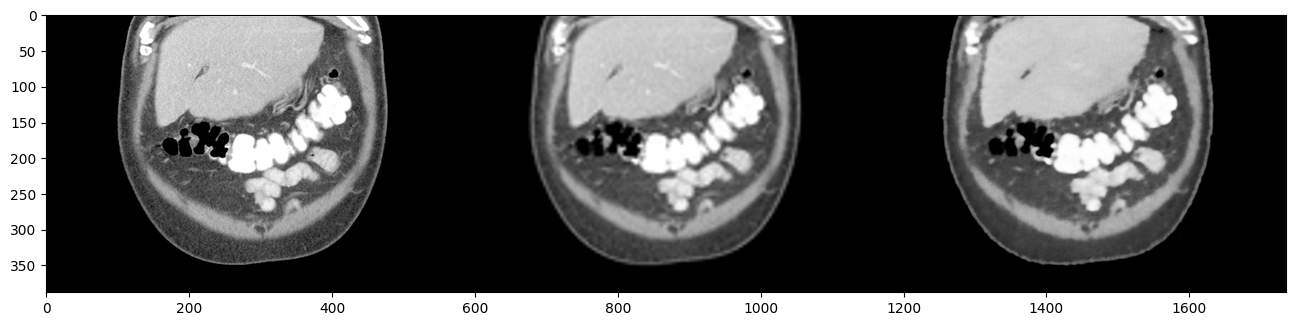

iteration:1200
Last 100 iterations PSNR_LR: [32.646055053387386, 32.61583819961787, 32.9946588274203, 32.837839344823486, 32.691096807814496, 32.88204121442364, 32.85473850463792, 32.825789212737135, 32.75253699645137, 32.91673753451889, 32.77284958984519, 32.957905766896914, 32.66305019122679, 32.88445251104341, 33.03364237791652, 32.844966023887395, 33.002562763369724, 33.18871340840515, 32.922940529032, 33.16576982223677, 32.86937271313321, 33.1089450022746, 33.117845185711225, 33.07386016441495, 33.20406031966393, 33.032080610537406, 32.829759107134436, 33.26240100483537, 32.857742193423, 33.036404915764905, 32.79261712266476, 32.98447903752711, 33.07473028789905, 32.72742529977367, 33.330494227725154, 32.79956659316482, 32.97523484082633, 32.60247768524779, 33.10064275119669, 32.83997044077214, 33.14222278549273, 32.9154496720482, 33.13466475644609, 32.976425401048886, 33.201960087413184, 33.145897718437936, 33.183587208531634, 32.79379034803175, 33.131941004117856, 33.05897297643

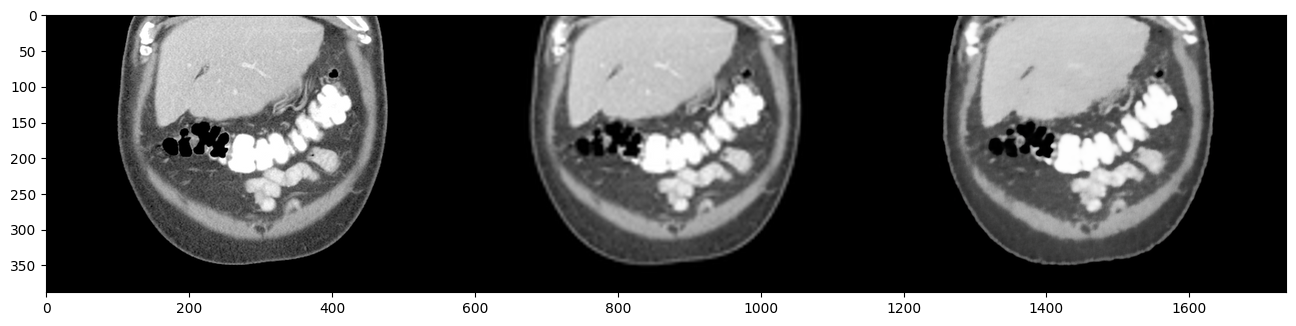

iteration:1300
Last 100 iterations PSNR_LR: [33.359817666747006, 33.479786512307065, 33.32981249124628, 33.39023146102488, 33.28315052560984, 33.33079497410621, 33.007728515806406, 33.44475200140947, 33.15102250906695, 33.279468805073186, 33.672164679814706, 33.04739807725377, 33.1419412457261, 33.41039606514505, 33.40571436401519, 33.2452728292754, 33.38399636854954, 33.60144771025613, 33.26974967337194, 33.1340080118801, 33.31770508575393, 33.55875445347631, 33.22717413486731, 33.65290607705846, 33.01367592621581, 33.072801404925734, 33.22071720023199, 33.417542526215904, 33.173943003153376, 33.24967536972065, 33.030547290556626, 33.1920759679478, 33.30576520340994, 33.66481229318914, 33.214624953489874, 33.20925984111969, 33.503822553428996, 33.56108738994619, 33.39554480059982, 33.13833140867378, 33.33961791616153, 33.5676976913389, 33.70662263711728, 33.46395154661173, 33.41512695443601, 33.33095826635748, 33.28324440733038, 33.541063444067134, 33.40541683519569, 33.58460808489686

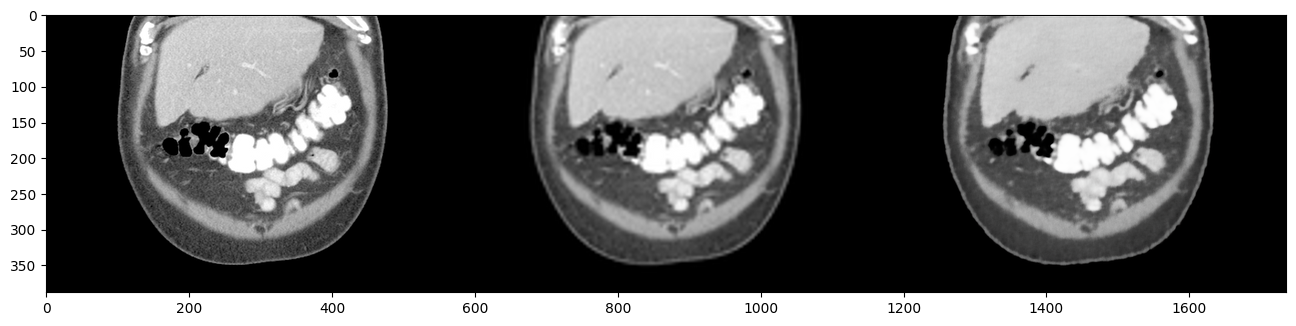

iteration:1400
Last 100 iterations PSNR_LR: [33.92012542860319, 33.824395856504516, 33.74928008392268, 33.810253499319614, 33.607102926443744, 33.95430311830188, 33.71146595632055, 33.65525639829415, 34.01167242146217, 33.935755542132185, 33.90105353326661, 33.66508107751041, 33.979360601047624, 33.68804507173485, 33.791999915164425, 33.52740633852166, 34.070917759913655, 33.76854515353383, 33.87363568768358, 33.88590102243826, 33.54762832413629, 33.86297602615596, 33.535531015434, 33.822268848274334, 33.77384626412235, 34.00169633148456, 33.78297588196203, 34.07828242923892, 33.88168587498965, 33.71362110323195, 33.797538214798564, 33.18401899552946, 33.949063041320876, 32.9275639177139, 33.58758909802698, 32.954138181859804, 33.426881249413995, 33.618297954146975, 33.636263571497224, 33.32282798310166, 33.59424229490257, 33.354568237611126, 33.945092689243324, 33.23675387363565, 33.78372564001508, 33.54234750862154, 33.18990698085388, 33.44934125023187, 33.83748874637134, 33.79935876

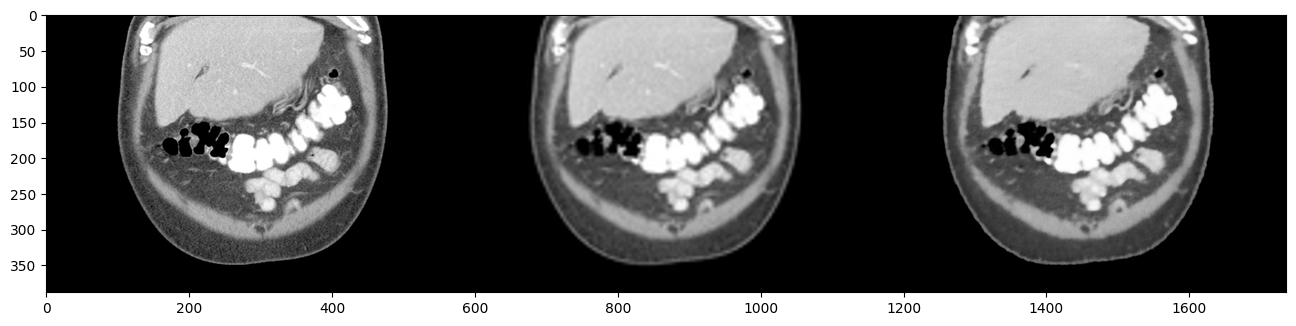

iteration:1500
Last 100 iterations PSNR_LR: [33.78001737621244, 34.104381810183966, 34.0867564138011, 34.21536555561055, 33.753877518300605, 33.92220477532751, 33.94086367290169, 33.97059219666645, 33.69364590468243, 34.221215512955254, 33.63033687417943, 33.88582872742794, 33.880191455636236, 33.96052827747819, 34.09786240325873, 34.012269461302715, 34.30770772681758, 33.68335973425541, 34.20787834295596, 33.61122867636003, 34.07875643076458, 34.10310210627985, 34.244780259986626, 34.04408152735323, 33.99543205760137, 34.29129753412772, 34.220678012379175, 34.11734976061584, 34.58993180766225, 34.40588983252506, 34.22874352375196, 34.534478494032896, 34.27296813019084, 34.2176092777352, 33.94995376033747, 34.252131876582, 33.59732501785865, 34.18315104388363, 34.06654410632973, 33.78513364265264, 33.92057093941928, 34.479317143982485, 34.319469823455556, 34.130216042711496, 34.33042167799819, 34.228806127425344, 33.90336666604804, 34.10385438654443, 34.285130004133585, 34.400804142247

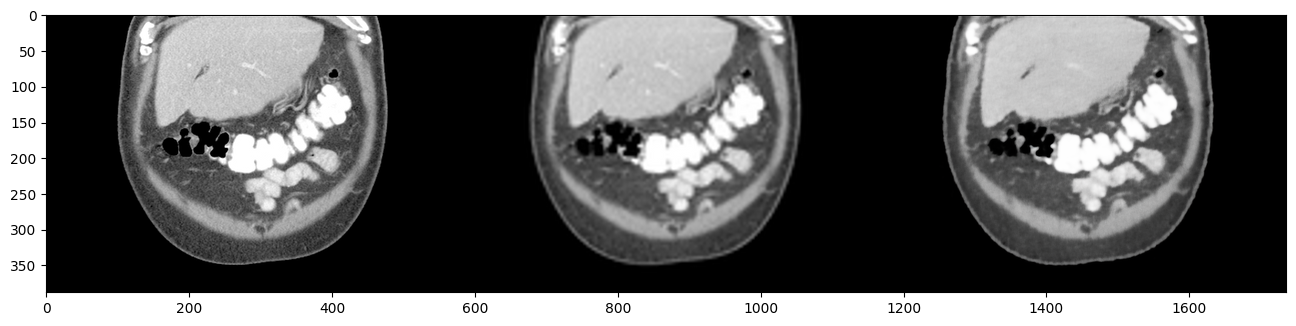

iteration:1600
Last 100 iterations PSNR_LR: [34.44746741337301, 34.304586597709175, 34.949835579831465, 34.58305351285545, 34.594100423142415, 34.577328827324706, 34.70222424556442, 34.505118953634295, 34.5487870462524, 34.53477847671465, 34.665798818728966, 34.342674387072975, 34.55325776092988, 34.39455566198831, 34.28297272919562, 34.184917316142744, 34.43456349132486, 34.36266974818535, 34.53834996477521, 34.31392338752531, 34.46505015759489, 34.65109821978873, 34.226188568575964, 34.80319196997559, 35.04895081969424, 34.561768211136524, 34.59674797968568, 34.28327648846842, 34.63248667805322, 34.644490607383155, 34.81733327295952, 34.82650536460188, 34.66164812634976, 34.141065330482206, 34.57582462330733, 34.70843546167096, 34.61138004640963, 34.67753764244072, 34.96149615653211, 34.40323184476553, 34.33063827442758, 34.41560210427555, 34.472872038656504, 34.494009070269406, 34.38757702356328, 34.202971258210624, 34.18527997206975, 34.459811137709735, 34.20721756726583, 34.411877

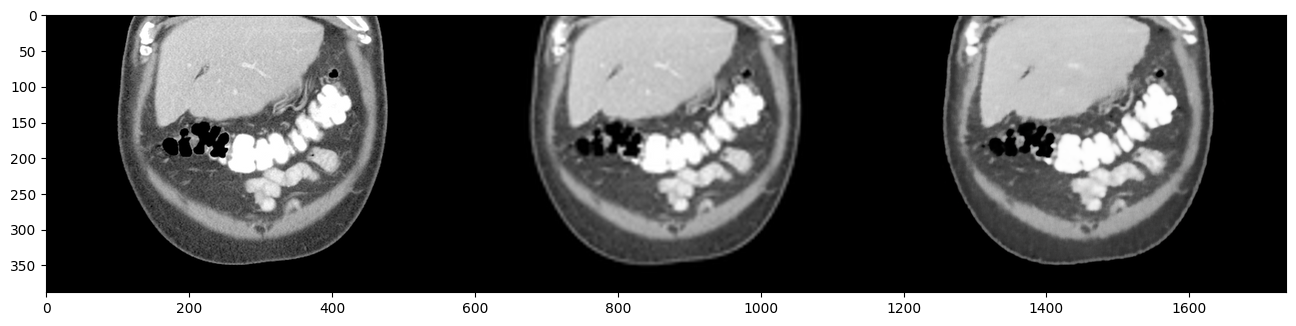

iteration:1700
Last 100 iterations PSNR_LR: [34.87857557105922, 34.44872428228078, 34.7829048605815, 34.56761194036817, 35.213297561783, 34.65334249583934, 34.807845934699316, 34.78847391067258, 35.15939337020009, 34.57952438390208, 34.800486682790506, 34.72500582993422, 34.992557450330224, 35.023684296791565, 34.75051837957703, 35.02351307212538, 34.939087902001475, 34.850272938181476, 35.052196699688004, 35.0270896741157, 34.68980824276416, 34.80976000977587, 34.82351773661667, 34.71300615015729, 34.90620305711538, 34.79497309914368, 34.881115890044114, 34.73830888449352, 34.979809590603395, 34.56532153556299, 35.002156750781126, 34.47119040459105, 34.60273424532722, 34.40793941698702, 34.54300176755423, 34.546824609241334, 34.503690850404965, 34.46049664834399, 35.02906041574336, 34.46722416324407, 34.49612181014524, 34.50955170781934, 34.72154192344108, 34.67515421489721, 34.93319519838116, 34.379435508721784, 34.48689029433242, 34.440029240912615, 34.343680772889364, 34.8675079440

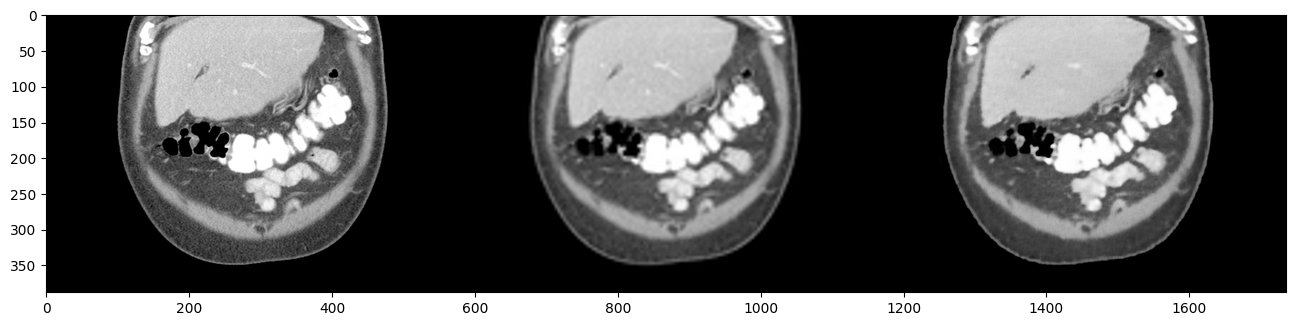

iteration:1800
Last 100 iterations PSNR_LR: [35.133056091257814, 35.06217889575687, 35.00573020282364, 35.275428530229014, 35.10820476609516, 35.24934841046872, 35.241829842410006, 35.23553921092304, 35.3217143139854, 35.36074103445945, 35.50092833854858, 35.19122499234833, 35.452768604342914, 35.51902850666146, 35.38508723432737, 35.31515514168432, 35.196792524940534, 35.38486650491703, 35.48568838810721, 35.24940068204168, 35.35570171273853, 35.0883328214116, 35.41583112027506, 35.25849769326707, 35.62114625207207, 35.29504456709572, 35.31026033595737, 35.362894814017196, 35.23961313487816, 35.25725557867204, 35.06510174799847, 35.073579728629355, 35.130835045778696, 35.398048096756135, 34.93341888746039, 35.195588677413184, 35.26081213092844, 35.24935730853906, 34.975966732417334, 35.04867538839569, 35.580822965704265, 35.338859890763324, 35.48848934057395, 35.448157404756, 35.55241594046041, 35.59595678701498, 35.30894672261992, 35.270384553641804, 35.30748773225391, 35.41143145533

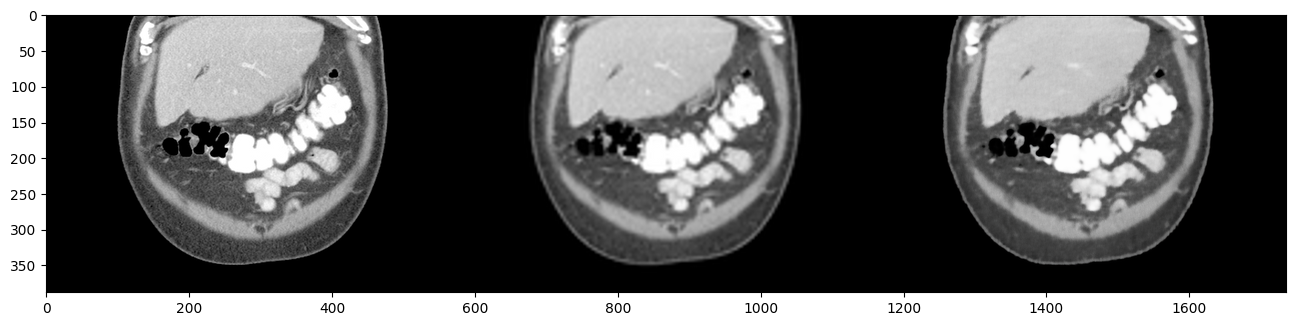

iteration:1900
Last 100 iterations PSNR_LR: [35.30676459315429, 35.36964282343705, 35.37935895314331, 35.68476845703731, 35.210746766719396, 35.54252267953581, 35.24202238321327, 35.49635794225249, 35.155400765019955, 35.90901667917231, 35.66043432779197, 35.48015245009897, 35.625549120186754, 35.43465398009936, 35.626567706889695, 35.36951008992179, 35.64286673237288, 35.68923184927065, 35.53588357947221, 35.758793807249006, 35.327186154735735, 35.86648404535961, 35.7294834264883, 35.614589393923815, 35.60287443646686, 35.4999571435243, 35.386040896891735, 35.33101431971683, 34.83104297023117, 35.45683186102885, 34.733713870095436, 35.36018756609057, 35.244854891559626, 35.118811818989634, 35.63983167374782, 35.39538971942628, 35.43320571820758, 35.17156747382348, 35.755785637657155, 35.27084423846222, 35.60022339152444, 35.52997657546976, 35.3254352857692, 35.616301483509496, 35.13908341831411, 35.355426321745256, 35.75582963791806, 35.88552300946646, 35.76984298222994, 35.5325501312

In [ ]:
psnr_history = []

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0

p = get_params(OPT_OVER, net, net_input)

optimize(OPTIMIZER, p, closure, LR, num_iter)




In [ ]:
psrn_HR_array = np.column_stack((np.arange(len(psrn_HR_list)), psrn_HR_list))
psrn_LR_array = np.column_stack((np.arange(len(psrn_LR_list)), psrn_LR_list))

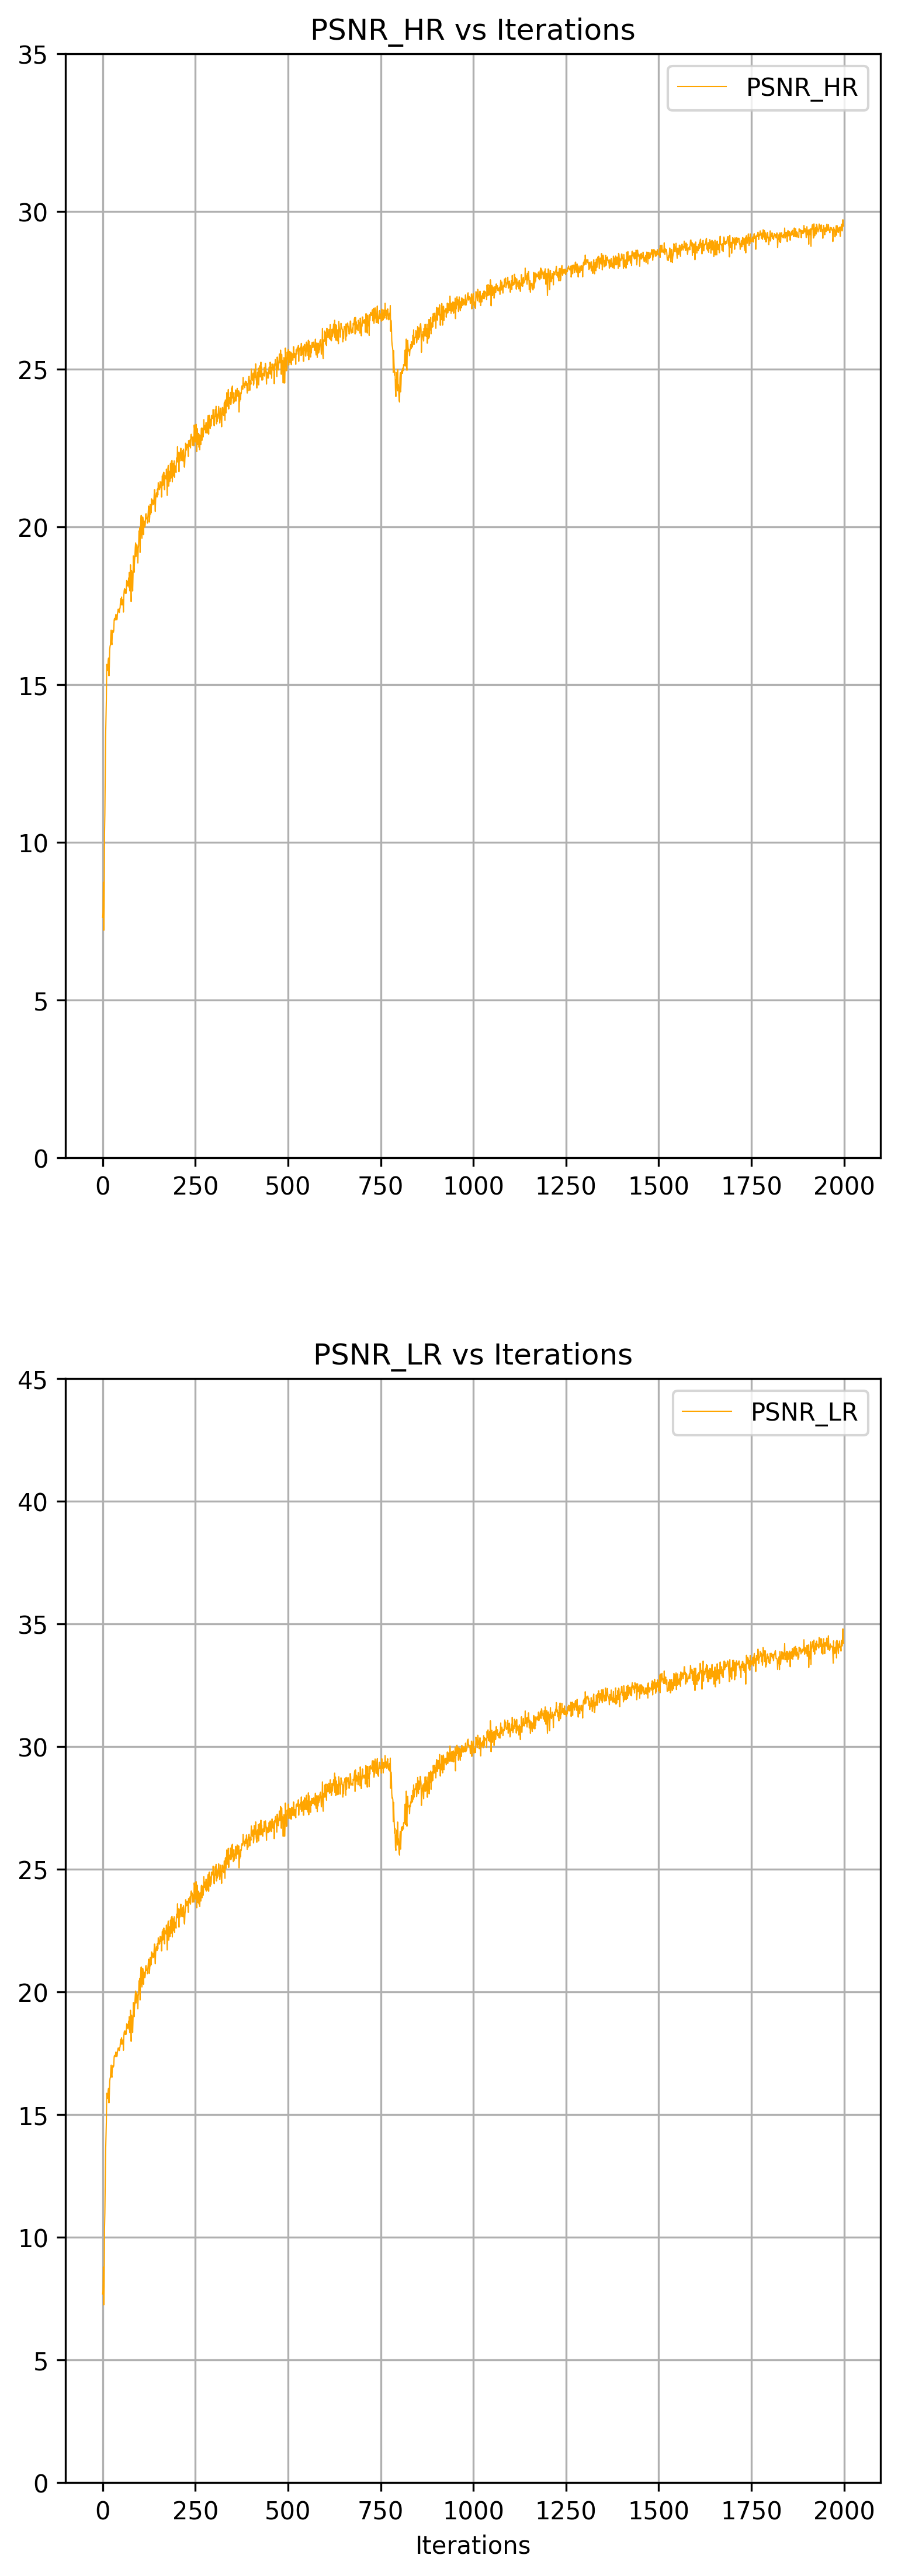

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, figsize=(6, 18), dpi=300)

if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

axs[0].plot(psrn_HR_array[:, 0], psrn_HR_array[:, 1], label='PSNR_HR', linewidth=0.5, color='orange' )
axs[0].set_title('PSNR_HR vs Iterations')
axs[0].set_ylim(0.000, 35)
axs[0].grid(True)
axs[0].legend()

axs[1].plot(psrn_LR_array[:, 0], psrn_LR_array[:, 1], label='PSNR_LR', linewidth=0.5, color='orange'   )
axs[1].set_title('PSNR_LR vs Iterations')
axs[1].set_ylim(0.000, 45)
axs[1].grid(True)
axs[1].legend()

plt.xlabel('Iterations')
plt.show()

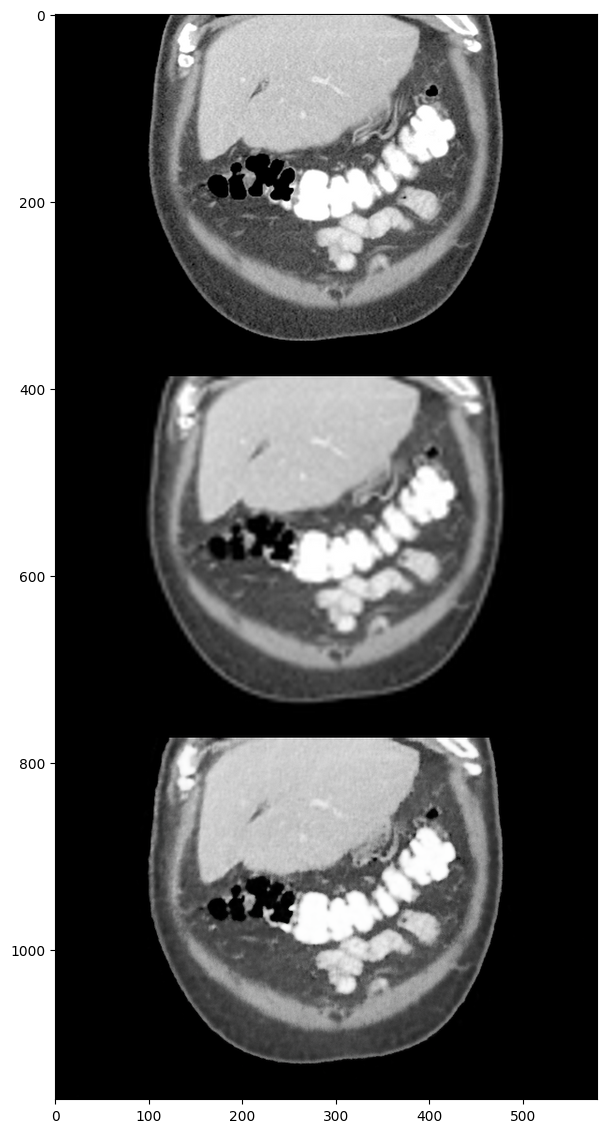

In [ ]:

out_HR_np = np.clip(torch_to_np(net(net_input)), 0, 1)


result_deep_prior = put_in_center(out_HR_np, imgs['orig_np'].shape[1:])

# For the paper we acually took `_bicubic.png` files from LapSRN viewer and used `result_deep_prior` as our result
plot_image_grid([imgs['HR_np'],
                 imgs['bicubic_np'],
                 out_HR_np], factor=4, nrow=1);